# 22216920213 孔令军花朵识别实验结果

# 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 下载数据集

# 您可以使用 TensorFlow 的内置函数下载并解压数据集。

In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 48s 0us/step


下载后，有可用的数据集。共有 3,670 张图像：

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


这里有一些玫瑰花：

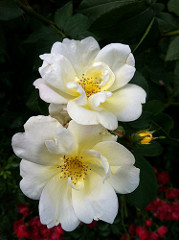

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

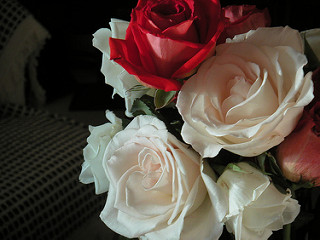

In [5]:
PIL.Image.open(str(roses[1]))

这是郁金香：

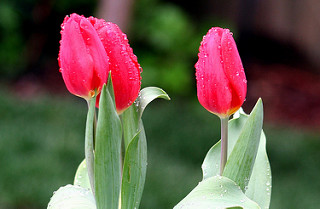

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

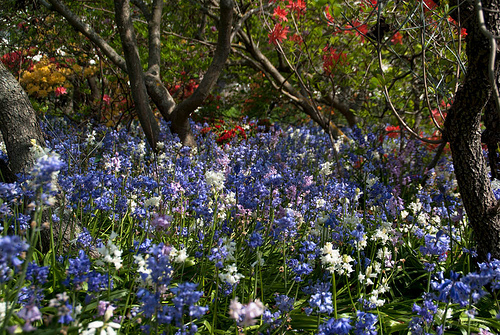

In [7]:
PIL.Image.open(str(tulips[1]))

使用Keras加载数据

接下来，从磁盘加载这些图像tf.keras.utils.image_dataset_from_directory。只需几行代码即可将您从磁盘上的图像目录加载数据。

### 创建数据集

为加载器定义一些参数：

In [8]:
batch_size = 32
img_height = 180
img_width = 180

使用 80% 的图像进行训练，20% 的图像进行验证

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


可以在这些数据集的属性中找到类名称class_names。这些对应于按字母顺序排列的目录名称。

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 可视化数据

以下是训练数据集中的前九张图像：

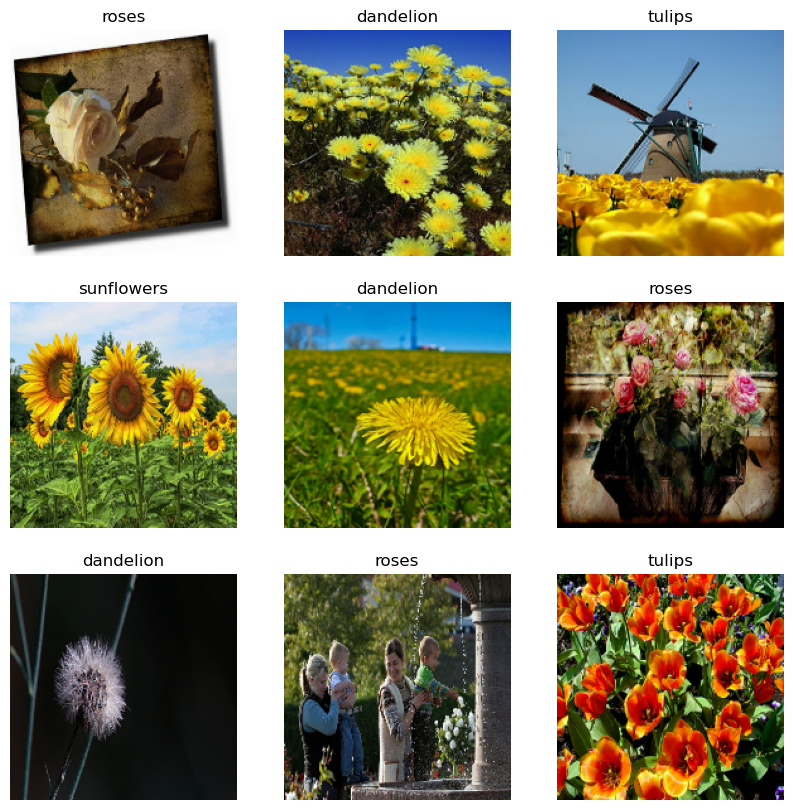

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


是image_batch形状的张量(32, 180, 180, 3)。这是一批 32 个形状图像180x180x3（最后一个维度指的是颜色通道 RGB）。是label_batch形状的张量(32,)，这些是 32 个图像的对应标签。

您可以调用.numpy()和image_batch张labels_batch量将它们转换为numpy.ndarray.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 标准化数据

RGB 通道值在范围内[0, 255]。这对于神经网络来说并不理想；一般来说，您应该设法减小输入值。

[0, 1]在这里，您将使用以下方法将值标准化为在该范围内tf.keras.layers.Rescaling：

In [15]:
normalization_layer = layers.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## 基于Keras创建模型

Keras模型由三个Conv2D( ) 组成，每个卷积块中都有tf.keras.layers.Conv2D和MaxPooling2D()。tf.keras.layers.MaxPooling2D有一个全连接层tf.keras.layers.Dense ( )。

In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 编译模型


In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 模型 summary

使用Keras方法查看网络的所有层Model.summary：

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### 训练模型

使用 Keras 方法将模型训练 10 个 epoch Model.fit：

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


92/92 [==============================] - 9s 82ms/step - loss: 1.3468 - accuracy: 0.4261 - val_loss: 1.0847 - val_accuracy: 0.5777
Epoch 2/10
92/92 [==============================] - 9s 100ms/step - loss: 0.9416 - accuracy: 0.6369 - val_loss: 0.9992 - val_accuracy: 0.6022
Epoch 3/10
92/92 [==============================] - 8s 85ms/step - loss: 0.7108 - accuracy: 0.7282 - val_loss: 0.9179 - val_accuracy: 0.6362
Epoch 4/10
92/92 [==============================] - 8s 86ms/step - loss: 0.4948 - accuracy: 0.8174 - val_loss: 0.9727 - val_accuracy: 0.6403
Epoch 5/10
92/92 [==============================] - 8s 87ms/step - loss: 0.2881 - accuracy: 0.9057 - val_loss: 1.1393 - val_accuracy: 0.6294
Epoch 6/10
92/92 [==============================] - 8s 88ms/step - loss: 0.1467 - accuracy: 0.9550 - val_loss: 1.4114 - val_accuracy: 0.6281
Epoch 7/10
92/92 [==============================] - 9s 94ms/step - loss: 0.0937 - accuracy: 0.9724 - val_loss: 1.4393 - val_accuracy: 0.6403
Epoch 8/10

## 可视化训练结果

创建训练集和验证集上的损失和准确性图：

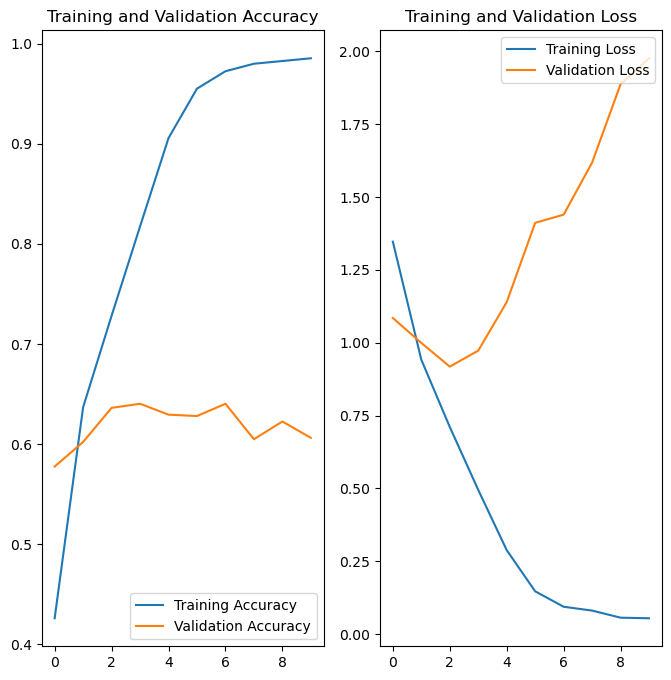

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

该图显示训练准确度和验证准确度相差很大，并且模型在验证集上仅达到 60% 左右的准确度。有什么办法提高准确率吗？

以下部分展示了如何检查问题并尝试提高模型的整体性能。

## 过拟合

在上图中，训练准确度随时间线性增加，而验证准确度在训练过程中停滞在 60% 左右。此外，训练准确度和验证准确度之间的准确度差异也很明显——这是过度拟合的迹象。

当训练示例数量较少时，模型有时会从训练示例中的噪声或不需要的细节中学习，从而对模型在新示例上的性能产生负面影响。这种现象称为过度拟合。这意味着该模型将很难在新数据集上进行泛化。

在训练过程中有多种方法可以对抗过度拟合。可以添加dropout防止过拟合 。

## 数据增强

当训练样本数量较少时，通常会发生过度拟合。数据增强采用的方法是通过使用随机转换来增强现有示例，从而生成额外的训练数据，从而生成可信的图像。这有助于让模型了解数据的更多方面并更好地进行概括。

使用 Keras 预处理层实现数据增强：tf.keras.layers.RandomFlip、tf.keras.layers.RandomRotation和tf.keras.layers.RandomZoom。这些可以像其他层一样包含在模型中，并在 GPU 上运行。

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

通过对同一张图像多次应用数据增强来可视化一些增强示例：

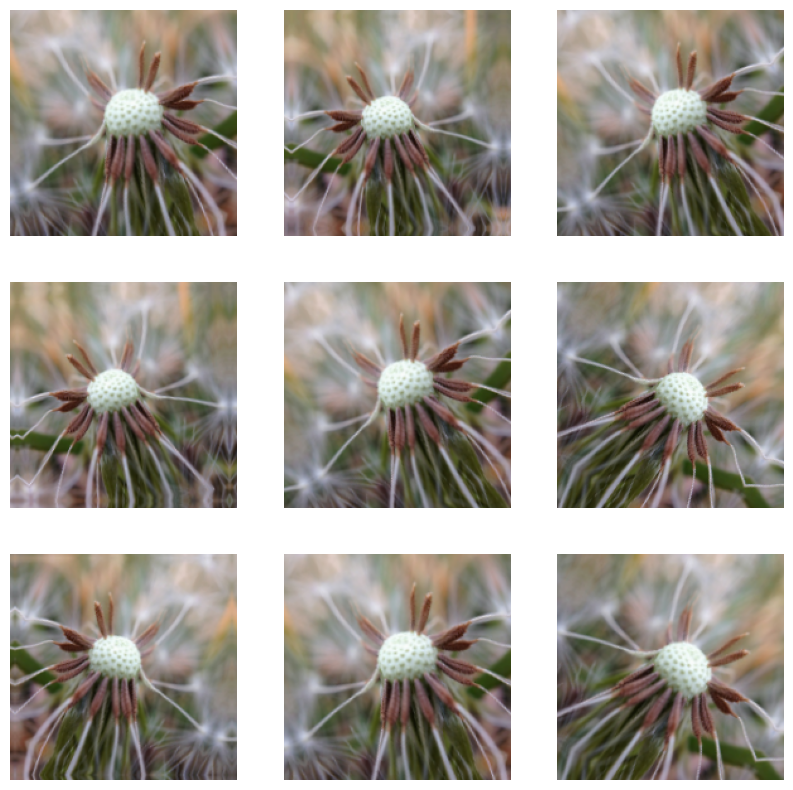

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout正则化

另一种减少过度拟合的技术是向网络引入dropout正则化。

当将 dropout 应用于某个层时，它会在训练过程中从该层中随机丢弃多个输出单元。Dropout以小数作为输入值，形式如0.1、0.2、0.4等。这意味着从应用层中随机丢弃10%、20%或40%的输出单元。

tf.keras.layers.Dropout在使用增强图像对其进行训练之前创建一个新的神经网络：

In [24]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## 编译并训练模型

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [27]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 10s 90ms/step - loss: 1.2541 - accuracy: 0.4734 - val_loss: 1.1159 - val_accuracy: 0.5627
Epoch 2/15
92/92 [==============================] - 8s 91ms/step - loss: 0.9913 - accuracy: 0.6087 - val_loss: 1.0006 - val_accuracy: 0.6117
Epoch 3/15
92/92 [==============================] - 9s 94ms/step - loss: 0.9100 - accuracy: 0.6512 - val_loss: 0.9951 - val_accuracy: 0.6185
Epoch 4/15
92/92 [==============================] - 9s 99ms/step - loss: 0.8934 - accuracy: 0.6502 - val_loss: 0.8622 - val_accuracy: 0.6567
Epoch 5/15
92/92 [==============================] - 10s 104ms/step - loss: 0.7918 - accuracy: 0.7016 - val_loss: 0.8959 - val_accuracy: 0.6403
Epoch 6/15
92/92 [==============================] - 11s 116ms/step - loss: 0.7566 - accuracy: 0.7091 - val_loss: 0.8813 - val_accuracy: 0.6458
Epoch 7/15
92/92 [==============================] - 11s 117ms/step - loss: 0.7225 - accuracy: 0.7285 - val_loss: 0.7398 - val_accuracy: 0.7057
Epoch 

## 可视化训练结果

应用数据增强 和 tf.keras.layers.Dropout后，过度拟合比以前更少，并且训练和验证准确性更好

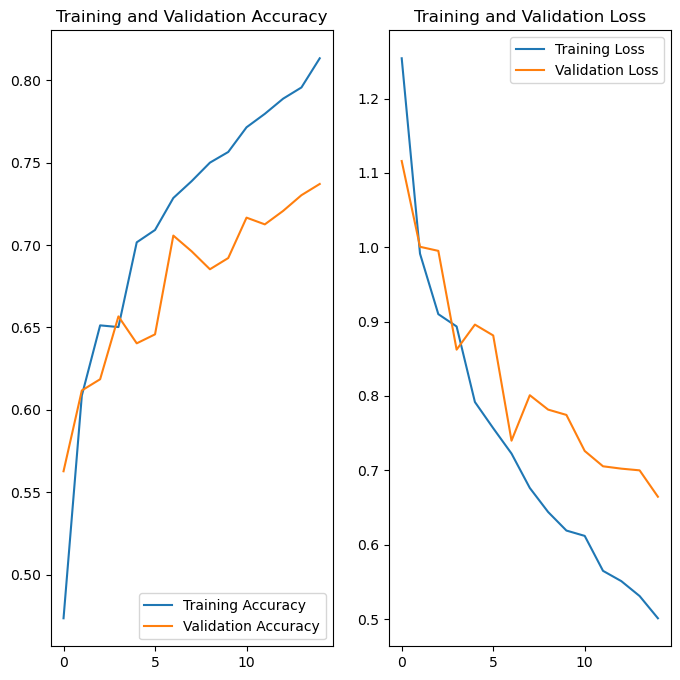

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 对新图片进行预测

使用训练好的模型对未包含在训练或验证集中的图像进行分类。

In [29]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 113ms/step
This image most likely belongs to sunflowers with a 93.97 percent confidence.
